In [1]:
import torch 
import torchvision
from torchvision.datasets import MNIST

## Working with Images


In [2]:
dataset = MNIST(root = 'traindata/', download = True)

In [3]:
len(dataset)

60000

The dataset has 60,000 images that we'll use to train the model. There is also an additional test set of 10,000 images used for evaluating models and reporting metrics in papers and reports. We can create the test dataset using the MNIST class by passing train=False to the constructor.

In [4]:
test_dataset = MNIST(root = 'testdata/',train = False, download = True)
len(test_dataset)

10000

In [5]:
dataset[1]

(<PIL.Image.Image image mode=L size=28x28 at 0x7F3AF31B3470>, 0)

It's a pair, consisting of a 28x28 px image and a label. The image is an object of the class PIL.Image.Image, which is a part of the Python imaging library Pillow. We can view the image within Jupyter using matplotlib, the de-facto plotting and graphing library for data science in Python.

Label: 0


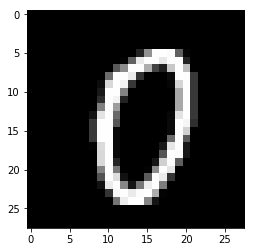

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

image, label = dataset[1000]
plt.imshow(image, cmap = 'gray')
print("Label:", label)

PyTorch datasets allow us to specify one or more transformation functions that are applied to the images as they are loaded. The torchvision.transforms module contains many such predefined functions. We'll use the ToTensor transform to convert images into PyTorch tensors.

In [7]:
import torchvision.transforms as transforms 
dataset = MNIST(root = 'traindata/', train = True, transform = transforms.ToTensor())

img_tensor, label = dataset[0]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 5


The image is now converted to a 1x28x28 tensor. The first dimension tracks color channels. The second and third dimensions represent pixels along the height and width of the image, respectively. Since images in the MNIST dataset are grayscale, there's just one channel. Other datasets have images with color, in which case there are three channels: red, green, and blue (RGB).

In [8]:
print(img_tensor[0, 10:15, 10:15])
print(torch.max(img_tensor), torch.min(img_tensor))

tensor([[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
        [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
        [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
        [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
        [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]])
tensor(1.) tensor(0.)


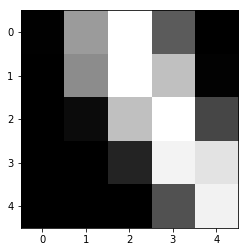

In [9]:
plt.imshow(img_tensor[0, 10:15, 10:15], cmap = 'gray')

## Training and Validation Datasets

Training set - used to train the model, i.e., compute the loss and adjust the model's weights using gradient descent.

Validation set - used to evaluate the model during training, adjust hyperparameters (learning rate, etc.), and pick the best version of the model.

Test set - used to compare different models or approaches and report the model's final accuracy.
In the MNIST dataset, there are 60,000 training images and 10,000 test images. The test set is standardized so that different researchers can report their models' results against the same collection of images.

Since there's no predefined validation set, we must manually split the 60,000 images into training and validation datasets. Let's set aside 10,000 randomly chosen images for validation. We can do this using the random_spilt method from PyTorch.

In [10]:
from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset, [50000, 10000])
len(train_ds), len(val_ds)

(50000, 10000)

It's essential to choose a random sample for creating a validation set. Training data is often sorted by the target labels, i.e., images of 0s, followed by 1s, followed by 2s, etc. If we create a validation set using the last 20% of images, it would only consist of 8s and 9s. In contrast, the training set would contain no 8s or 9s. Such a training-validation would make it impossible to train a useful model.

In [11]:
from torch.utils.data import DataLoader #with dataloader check tensordataset which is used to combine data and labels.

batch_size = 128
train_loader = DataLoader(train_ds, shuffle = True, batch_size = 128)
val_loader = DataLoader(val_ds, batch_size = 128)

## Model

In [12]:
import torch.nn as nn

input_size = 28*28
num_classes = 10
model = nn.Linear(input_size, num_classes)

print(list(model.parameters()))
print("weight shape:", model.weight.shape)
print("bias shape:", model.bias.shape)

[Parameter containing:
tensor([[-0.0265,  0.0321,  0.0208,  ...,  0.0239, -0.0315, -0.0265],
        [ 0.0062,  0.0154,  0.0212,  ..., -0.0131,  0.0181, -0.0150],
        [-0.0140,  0.0096, -0.0348,  ...,  0.0318, -0.0130, -0.0002],
        ...,
        [-0.0044, -0.0301, -0.0257,  ..., -0.0024, -0.0351,  0.0026],
        [ 0.0314, -0.0104, -0.0119,  ..., -0.0027, -0.0078,  0.0276],
        [ 0.0001, -0.0336, -0.0281,  ..., -0.0056,  0.0101, -0.0276]],
       requires_grad=True), Parameter containing:
tensor([-0.0162, -0.0284, -0.0022,  0.0055,  0.0157, -0.0118,  0.0079, -0.0218,
        -0.0181, -0.0178], requires_grad=True)]
weight shape: torch.Size([10, 784])
bias shape: torch.Size([10])


In [13]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
model = MnistModel()

In [14]:
print("model weights shape:",model.linear.weight.shape)
print("model bias shape:",model.linear.bias.shape)

model weights shape: torch.Size([10, 784])
model bias shape: torch.Size([10])


In [15]:
for images, labels in train_loader:
    outputs = model.forward(images)
    break

print('Output shape:', outputs.shape)
print('Sample output:', outputs[:1].data)

Output shape: torch.Size([128, 10])
Sample output: tensor([[ 0.1932,  0.2198,  0.1162, -0.0137, -0.0994,  0.1978,  0.0163,  0.0714,
          0.0233, -0.0859]])


In [16]:
import torch.nn.functional as F

probs = F.softmax(outputs, dim = 1)
print("Sample probabilities:", probs[:1])

print("Sum:", torch.sum(probs[1]).item())

Sample probabilities: tensor([[0.1131, 0.1162, 0.1047, 0.0920, 0.0844, 0.1136, 0.0948, 0.1001, 0.0954,
         0.0856]], grad_fn=<SliceBackward>)
Sum: 0.9999999403953552


In [17]:
max_probs, preds = torch.max(probs, dim = 1)
print('preds:', preds)
print('labels:', labels)

preds: tensor([1, 1, 1, 1, 2, 3, 7, 5, 3, 5, 1, 3, 3, 5, 3, 1, 2, 5, 3, 3, 5, 1, 1, 5,
        1, 1, 3, 3, 5, 3, 3, 1, 1, 2, 5, 1, 1, 6, 1, 3, 1, 7, 3, 5, 4, 2, 3, 1,
        3, 1, 1, 5, 1, 3, 5, 5, 5, 3, 2, 4, 4, 2, 4, 1, 5, 3, 4, 5, 5, 2, 3, 3,
        7, 4, 5, 3, 5, 1, 1, 6, 5, 7, 3, 5, 3, 3, 3, 2, 2, 5, 3, 5, 5, 1, 3, 5,
        2, 5, 1, 5, 5, 7, 2, 3, 4, 3, 1, 2, 3, 3, 4, 3, 7, 3, 4, 1, 1, 1, 2, 2,
        5, 3, 4, 1, 3, 5, 3, 5])
labels: tensor([6, 4, 4, 7, 4, 4, 4, 9, 8, 6, 5, 0, 0, 3, 5, 1, 8, 7, 8, 0, 4, 1, 1, 7,
        7, 1, 8, 3, 9, 0, 7, 7, 3, 8, 5, 1, 5, 0, 1, 3, 1, 7, 7, 9, 6, 9, 9, 5,
        3, 1, 1, 9, 1, 5, 4, 0, 6, 3, 9, 0, 8, 4, 2, 5, 6, 3, 0, 4, 6, 4, 3, 0,
        9, 0, 4, 9, 9, 6, 1, 6, 1, 7, 9, 9, 0, 4, 5, 3, 3, 7, 2, 4, 5, 6, 0, 4,
        8, 1, 6, 6, 4, 7, 8, 0, 2, 3, 1, 4, 3, 3, 5, 1, 7, 4, 0, 6, 1, 6, 4, 8,
        6, 7, 2, 5, 9, 9, 8, 4])


Most of the predicted labels are different from the actual labels. That's because we have started with randomly initialized weights and biases. We need to train the model, i.e., adjust the weights using gradient descent to make better predictions.

## Evaluation Metric and Loss Function

In [18]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds == labels)/ preds.numel())

accuracy(outputs, labels)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


tensor(0.2266)

Accuracy is an excellent way for us (humans) to evaluate the model. However, we can't use it as a loss function for optimizing our model using gradient descent for the following reasons:

It's not a differentiable function. torch.max and == are both non-continuous and non-differentiable operations, so we can't use the accuracy for computing gradients w.r.t the weights and biases.

It doesn't take into account the actual probabilities predicted by the model, so it can't provide sufficient feedback for incremental improvements.

For these reasons, accuracy is often used as an evaluation metric for classification, but not as a loss function. A commonly used loss function for classification problems is the cross-entropy.

PyTorch provides an efficient and tensor-friendly implementation of cross-entropy as part of the torch.nn.functional package. Moreover, it also performs softmax internally, so we can directly pass in the model's outputs without converting them into probabilities.

In [19]:
loss_fn = F.cross_entropy
loss = loss_fn(outputs, labels)
print(loss)

tensor(2.2894, grad_fn=<NllLossBackward>)


## Training the Model

for epoch in range(num_epochs):\
    for batch in train_loader:
        # train the model
        # compute loss
        # cal gradients
        # update weights
        # reset gradients
     for batch in val_loader:
        # generate predictions
        # calculate loss
        # calculate metrics
     #calculate average validation loss & accuracy

 redefining the MnistModel class to include additional methods training_step, validation_step, validation_epoch_end, and epoch_end used by fit and evaluate.

In [20]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch
        out = self.forward(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self.forward(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss, 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

model = MnistModel()

In [21]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [22]:
def fit(num_epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = []
    for epoch in range(num_epochs):
        # instead of pred = model.forward() and loss = loss_fn(pred, y)
        for batch in train_loader:
            loss = model.training_step(batch) 
            loss.backward() #calculates gradient of parameters
            optimizer.step() #parameter update using current .grad values
            optimizer.zero_grad() #as gradient accumulates in .grad so we need to make it zero after update
    
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history 

Before we train the model, let's see how the model performs on the validation set with the initial set of randomly initialized weights & biases.

In [23]:
result0 = evaluate(model, val_loader)
result0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


{'val_loss': 2.3055222034454346, 'val_acc': 0.10462816804647446}

The initial accuracy is around 10%, which one might expect from a randomly initialized model (since it has a 1 in 10 chance of getting a label right by guessing randomly).

In [24]:
history1 = fit(5, 0.001, model, train_loader, val_loader, opt_func = torch.optim.SGD)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch [0], val_loss: 1.9355, val_acc: 0.6300
Epoch [1], val_loss: 1.6673, val_acc: 0.7393
Epoch [2], val_loss: 1.4675, val_acc: 0.7727
Epoch [3], val_loss: 1.3170, val_acc: 0.7885
Epoch [4], val_loss: 1.2012, val_acc: 0.7998


In [25]:
history2 = fit(5, 0.001, model, train_loader, val_loader, opt_func = torch.optim.SGD)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch [0], val_loss: 1.1102, val_acc: 0.8087
Epoch [1], val_loss: 1.0373, val_acc: 0.8177
Epoch [2], val_loss: 0.9777, val_acc: 0.8241
Epoch [3], val_loss: 0.9281, val_acc: 0.8294
Epoch [4], val_loss: 0.8861, val_acc: 0.8331


In [26]:
history3 = fit(5, 0.001, model, train_loader, val_loader, opt_func = torch.optim.SGD)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch [0], val_loss: 0.8501, val_acc: 0.8359
Epoch [1], val_loss: 0.8190, val_acc: 0.8398
Epoch [2], val_loss: 0.7916, val_acc: 0.8428
Epoch [3], val_loss: 0.7675, val_acc: 0.8452
Epoch [4], val_loss: 0.7461, val_acc: 0.8471


In [27]:
history4 = fit(5, 0.001, model, train_loader, val_loader, opt_func = torch.optim.SGD)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch [0], val_loss: 0.7268, val_acc: 0.8496
Epoch [1], val_loss: 0.7095, val_acc: 0.8511
Epoch [2], val_loss: 0.6936, val_acc: 0.8535
Epoch [3], val_loss: 0.6792, val_acc: 0.8553
Epoch [4], val_loss: 0.6661, val_acc: 0.8565


While the accuracy does continue to increase as we train for more epochs, the improvements get smaller with every epoch. Let's visualize this using a line graph.

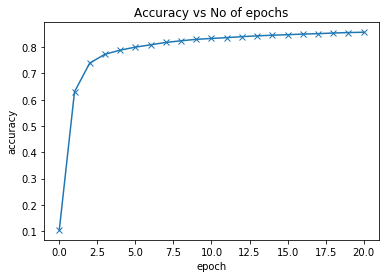

In [28]:
history = [result0] + history1 + history2 + history3 + history4
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs No of epochs')

It's quite clear from the above picture that the model probably won't cross the accuracy threshold of 90% even after training for a very long time. One possible reason for this is that the learning rate might be too high. The model's parameters may be "bouncing" around the optimal set of parameters for the lowest loss. You can try reducing the learning rate and training for a few more epochs to see if it helps.

## Testing with individual images

In [29]:
test_dataset = MNIST(root = 'testdata/',train = False, download = True, transform = transforms.ToTensor())
len(test_dataset)

10000

shape: torch.Size([1, 28, 28])
Label: 7


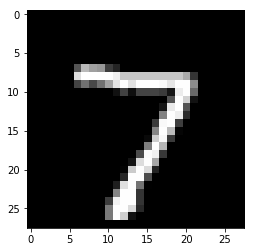

In [30]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap = 'gray')
print('shape:', img.shape)
print('Label:', label)

Label: 7 ,predicted: 7


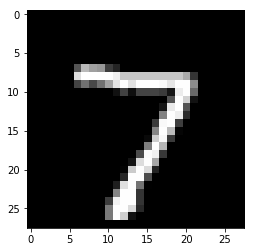

In [31]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim = 1)
    return preds[0].item()

img, label = test_dataset[0]
plt.imshow(img[0], cmap = 'gray')
print('Label:', label, ',predicted:', predict_image(img, model))

As our model always require batch of images as input so we input batch of size 1. img.unsqueeze simply adds another dimension at the begining of the 1x28x28 tensor, making it a 1x1x28x28 tensor, which the model views as a batch containing a single image.



Label: 0 ,predicted: 0


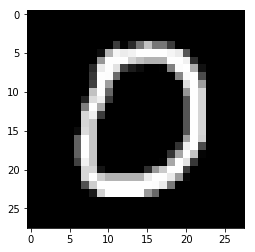

In [32]:
img, label = test_dataset[10]
plt.imshow(img[0], cmap = 'gray')
print('Label:', label, ',predicted:', predict_image(img, model))

Label: 9 ,predicted: 4


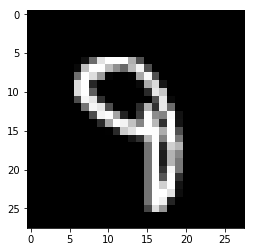

In [33]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap = 'gray')
print('Label:', label, ',predicted:', predict_image(img, model))

Label: 2 ,predicted: 8


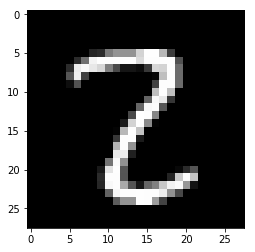

In [34]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap = 'gray')
print('Label:', label, ',predicted:', predict_image(img, model))

Identifying where our model performs poorly can help us improve the model, by collecting more training data, increasing/decreasing the complexity of the model, and changing the hypeparameters.

As a final step, let's also look at the overall loss and accuracy of the model on the test set.

In [38]:
test_loader = DataLoader(test_dataset, shuffle = True, batch_size = 1024)
result = evaluate(model, test_loader)
result

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


{'val_loss': 0.6443870663642883, 'val_acc': 0.864815890789032}

## Saving and loading the model

In [41]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.0228,  0.0044,  0.0320,  ...,  0.0190, -0.0125,  0.0334],
                      [ 0.0162, -0.0049, -0.0139,  ...,  0.0027,  0.0168, -0.0010],
                      [-0.0354,  0.0040, -0.0228,  ..., -0.0122, -0.0245, -0.0249],
                      ...,
                      [ 0.0214,  0.0108,  0.0345,  ..., -0.0318, -0.0122, -0.0131],
                      [-0.0127,  0.0172,  0.0006,  ...,  0.0095, -0.0199, -0.0151],
                      [ 0.0121, -0.0302,  0.0143,  ...,  0.0132, -0.0077, -0.0318]])),
             ('linear.bias',
              tensor([-0.0570,  0.0569,  0.0022, -0.0125,  0.0010,  0.0357, -0.0333,  0.0636,
                      -0.1027, -0.0329]))])

The .state_dict method returns an OrderedDict containing all the weights and bias matrices mapped to the right attributes of the model.

In [47]:
torch.save(model.state_dict(), 'mnist-logistic.pth')

In [48]:
model2 = MnistModel()
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.0118,  0.0084, -0.0004,  ..., -0.0097, -0.0250,  0.0311],
                      [ 0.0080,  0.0084,  0.0069,  ..., -0.0092, -0.0096,  0.0097],
                      [-0.0278,  0.0345,  0.0055,  ..., -0.0186,  0.0141,  0.0165],
                      ...,
                      [-0.0252,  0.0085, -0.0052,  ..., -0.0268, -0.0118, -0.0190],
                      [ 0.0262,  0.0207,  0.0227,  ..., -0.0231,  0.0292, -0.0260],
                      [-0.0146, -0.0337,  0.0020,  ..., -0.0155, -0.0282, -0.0068]])),
             ('linear.bias',
              tensor([ 0.0261,  0.0018,  0.0213, -0.0091, -0.0070,  0.0284,  0.0129,  0.0120,
                       0.0313, -0.0132]))])

In [49]:
evaluate(model2, test_loader)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


{'val_loss': 2.3220322132110596, 'val_acc': 0.11022601276636124}

In [50]:
model2.load_state_dict(torch.load('mnist-logistic.pth'))
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.0228,  0.0044,  0.0320,  ...,  0.0190, -0.0125,  0.0334],
                      [ 0.0162, -0.0049, -0.0139,  ...,  0.0027,  0.0168, -0.0010],
                      [-0.0354,  0.0040, -0.0228,  ..., -0.0122, -0.0245, -0.0249],
                      ...,
                      [ 0.0214,  0.0108,  0.0345,  ..., -0.0318, -0.0122, -0.0131],
                      [-0.0127,  0.0172,  0.0006,  ...,  0.0095, -0.0199, -0.0151],
                      [ 0.0121, -0.0302,  0.0143,  ...,  0.0132, -0.0077, -0.0318]])),
             ('linear.bias',
              tensor([-0.0570,  0.0569,  0.0022, -0.0125,  0.0010,  0.0357, -0.0333,  0.0636,
                      -0.1027, -0.0329]))])

In [52]:
evaluate(model2, test_loader)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


{'val_loss': 0.643673300743103, 'val_acc': 0.8652044534683228}